# Kardio: Using KNN to Advance Predictive Analytics for Heart Disease Diagnosis

**Group:** 3

**Members:** Maggie Cui, Tristan Heilbron, David Li, Ivy Nguyen

## Introduction

TODO

## Methods

TODO

## Data processing

### Loading required libraries

In [1]:
library(tidyverse)
library(tidymodels)
library(cowplot)
library(repr)
library(RColorBrewer)

# Setting a seed so our analysis is random but reproducible
set.seed(2005)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### Loading the dataset

In [2]:
cleveland_data_url <- "https://raw.githubusercontent.com/MYYaaa/datascience_project_group3/main/data/processed.cleveland.data"
hungarian_data_url <- "https://raw.githubusercontent.com/MYYaaa/datascience_project_group3/main/data/processed.hungarian.data"

data_column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

cleveland_data <- read_csv(cleveland_data_url, col_names = data_column_names)
hungarian_data <- read_csv(hungarian_data_url, col_names = data_column_names)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thal
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Cleaning and wrangling the data

In [3]:
# Substituting all "?" with NA
# REFERENCE: https://stackoverflow.com/a/19503330
cleveland_data[cleveland_data == "?"] <- NA
hungarian_data[hungarian_data == "?"] <- NA

In [4]:
# Converting to correct data types
numeric_column_names <- c("age", "trestbps", "chol", "thalach", "oldpeak", "ca")
factor_column_names <- c("sex", "cp", "fbs", "restecg", "exang", "slope", "thal", "num")

cleveland_data <- cleveland_data |>
    mutate(across(all_of(numeric_column_names), as.numeric)) |>
    mutate(across(all_of(factor_column_names), as_factor))

hungarian_data <- hungarian_data |>
    mutate(across(all_of(numeric_column_names), as.numeric)) |>
    mutate(across(all_of(factor_column_names), as_factor))

In [5]:
# Combining the two data sets
heart_disease_data <- bind_rows(cleveland_data, hungarian_data)

In [6]:
# Make the label variable more readable
heart_disease_data <- heart_disease_data |>
    mutate(diagnosis = fct_recode(num, "absent" = "0", "present" = "1", "present" = "2", "present" = "3", "present" = "4")) |>
    # Move the label to be the first column
    relocate(diagnosis) |>
    select(-num)

In [7]:
# Display the tidied data set with all variables
glimpse(heart_disease_data)

Rows: 597
Columns: 14
$ diagnosis <fct> absent, present, present, absent, absent, absent, present, a…
$ age       <dbl> 63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56, 56, 44, 52, …
$ sex       <fct> 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, …
$ cp        <fct> 1, 4, 4, 3, 2, 2, 4, 4, 4, 4, 4, 2, 3, 2, 3, 3, 2, 4, 3, 2, …
$ trestbps  <dbl> 145, 160, 120, 130, 130, 120, 140, 120, 130, 140, 140, 140, …
$ chol      <dbl> 233, 286, 229, 250, 204, 236, 268, 354, 254, 203, 192, 294, …
$ fbs       <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, …
$ restecg   <fct> 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, …
$ thalach   <dbl> 150, 108, 129, 187, 172, 178, 160, 163, 147, 155, 148, 153, …
$ exang     <fct> 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, …
$ oldpeak   <dbl> 2.3, 1.5, 2.6, 3.5, 1.4, 0.8, 3.6, 0.6, 1.4, 3.1, 0.4, 1.3, …
$ slope     <fct> 3, 2, 2, 3, 1, 1, 3, 1, 2, 3, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, …
$ ca        <dbl> 

In [8]:
# Select only the variables we plan on using
variables_of_interest <- c("diagnosis", "age", "trestbps", "chol", "thalach", "oldpeak")

heart_disease_data <- select(heart_disease_data, all_of(variables_of_interest))

In [9]:
# Display the tidied data set with only the variables we are using
glimpse(heart_disease_data)

Rows: 597
Columns: 6
$ diagnosis <fct> absent, present, present, absent, absent, absent, present, a…
$ age       <dbl> 63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56, 56, 44, 52, …
$ trestbps  <dbl> 145, 160, 120, 130, 130, 120, 140, 120, 130, 140, 140, 140, …
$ chol      <dbl> 233, 286, 229, 250, 204, 236, 268, 354, 254, 203, 192, 294, …
$ thalach   <dbl> 150, 108, 129, 187, 172, 178, 160, 163, 147, 155, 148, 153, …
$ oldpeak   <dbl> 2.3, 1.5, 2.6, 3.5, 1.4, 0.8, 3.6, 0.6, 1.4, 3.1, 0.4, 1.3, …


### Splitting the data

In [10]:
# Setting a seed so our analysis is random but reproducible
set.seed(2005)

heart_disease_data_split <- heart_disease_data |>
    initial_split(prop = 0.75, strata = diagnosis)

heart_disease_training <- training(heart_disease_data_split)
heart_disease_testing <- testing(heart_disease_data_split)

## Exploratory data analysis

### Summary of training data

In [11]:
# Display the number of observations for each diagnoses

total_observation_count <- nrow(heart_disease_training)

observation_count_summary <- heart_disease_training |>
    group_by(diagnosis) |>
    summarize(number_of_observations = n(),
              percentage = (n() / total_observation_count) * 100)

observation_count_summary

diagnosis,number_of_observations,percentage
<fct>,<int>,<dbl>
absent,264,59.0604
present,183,40.9396


In [12]:
# Display number of rows with missing data

missing_data_summary <- heart_disease_training |>
    group_by(diagnosis) |>
    filter(if_any(everything(), is.na)) |>
    summarize(number_of_rows_with_missing_values = n())

missing_data_summary

diagnosis,number_of_rows_with_missing_values
<fct>,<int>
absent,16
present,2


In [13]:
# Display the average value of predictor variables

average_value_summary <- heart_disease_training |>
    # Add a suffix to the column names except for diagnosis
    # REFERENCE: https://dplyr.tidyverse.org/reference/rename.html
    rename_with(~ paste(.x, "average", sep = "_"), -diagnosis) |>
    group_by(diagnosis) |>
    summarize(across(everything(), ~ mean(.x, na.rm = TRUE)))

average_value_summary

diagnosis,age_average,trestbps_average,chol_average,thalach_average,oldpeak_average
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
absent,50.06061,130.5095,243.2570,149.4981,0.4117424
present,53.72678,135.8743,260.5801,134.3607,1.3595628


### Visualization of training data

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”
Warning message:
“Removed 17 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”


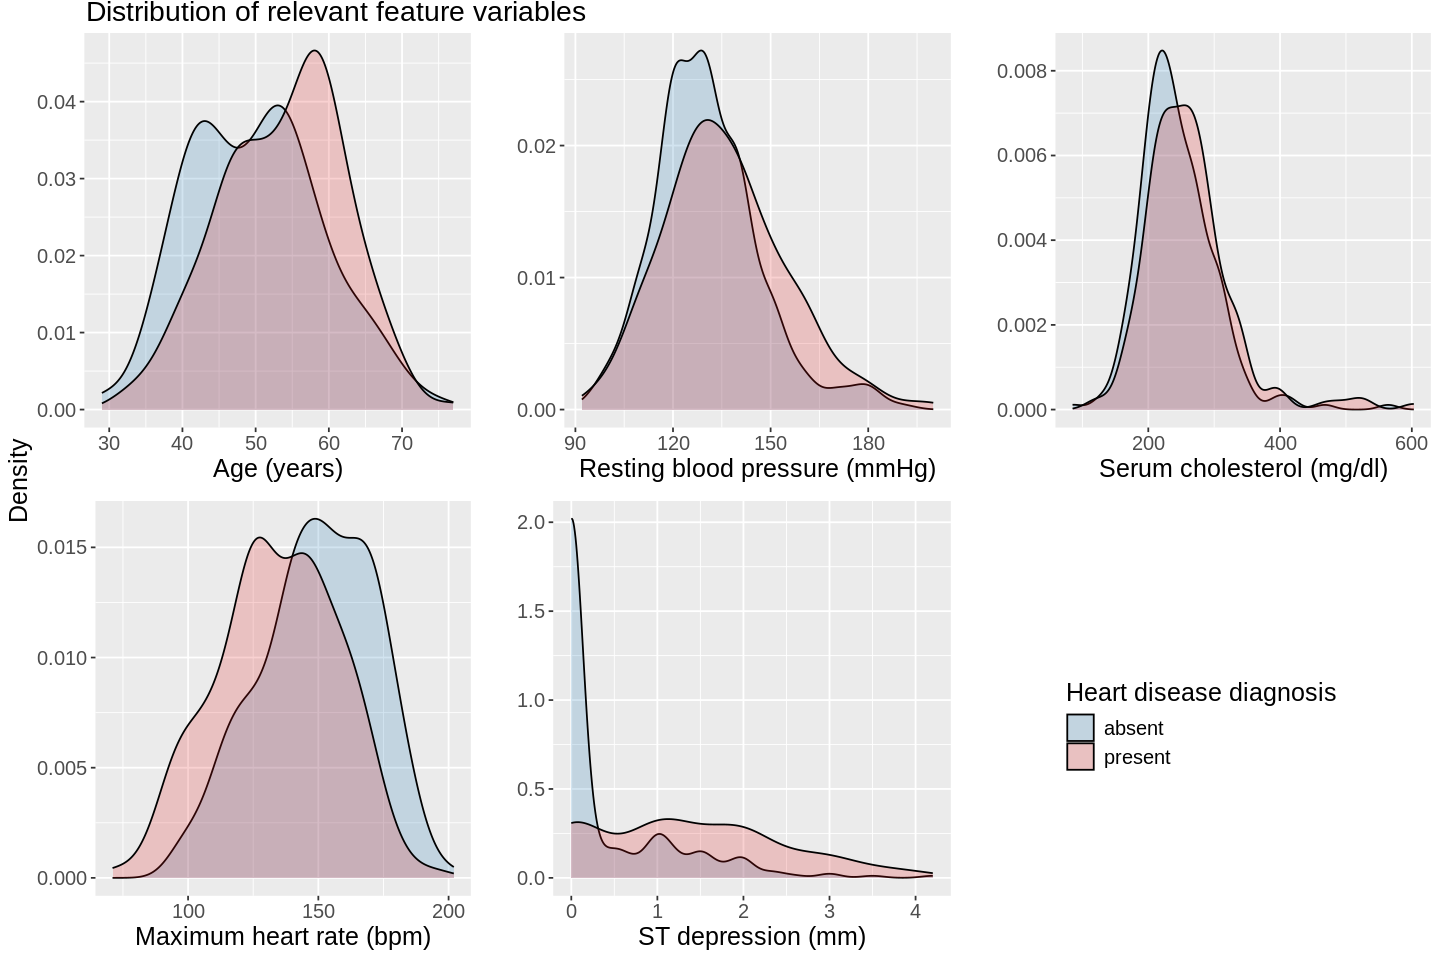

In [14]:
# Visualize the distribution of our relevant feature variables
options(repr.plot.width = 12, repr.plot.height = 8)

# Create a distribution plot for all feature variables
# with some colour blind friendly fill colours
age_distribution_plot <- heart_disease_training |>
    ggplot(aes(x = age, fill = diagnosis)) +
        geom_density(alpha = 0.2) +
        labs(x = "Age (years)", y = "",
             fill = "Heart disease diagnosis") +
        theme(text = element_text(size = 15),
              legend.direction = "vertical") +
        scale_fill_manual(values = c("#1F78B4", "#E31A1C"))

trestbps_distribution_plot <- heart_disease_training |>
    ggplot(aes(x = trestbps, fill = diagnosis)) +
        geom_density(alpha = 0.2) +
        labs(x = "Resting blood pressure (mmHg)", y = "") +
        theme(text = element_text(size = 15),
              legend.position = "none") +
        scale_fill_manual(values = c("#1F78B4", "#E31A1C"))

chol_distribution_plot <- heart_disease_training |>
    ggplot(aes(x = chol, fill = diagnosis)) +
        geom_density(alpha = 0.2) +
        labs(x = "Serum cholesterol (mg/dl)", y = "") +
        theme(text = element_text(size = 15),
              legend.position = "none") +
        scale_fill_manual(values = c("#1F78B4", "#E31A1C"))

thalach_distribution_plot <- heart_disease_training |>
    ggplot(aes(x = thalach, fill = diagnosis)) +
        geom_density(alpha = 0.2) +
        labs(x = "Maximum heart rate (bpm)", y = "") +
        theme(text = element_text(size = 15),
              legend.position = "none") +
        scale_fill_manual(values = c("#1F78B4", "#E31A1C"))

oldpeak_distribution_plot <- heart_disease_training |>
    ggplot(aes(x = oldpeak, fill = diagnosis)) +
        geom_density(alpha = 0.2) +
        labs(x = "ST depression (mm)", y = "") +
        theme(text = element_text(size = 15),
              legend.position = "none") +
        scale_fill_manual(values = c("#1F78B4", "#E31A1C"))

# REFERENCES:
# https://wilkelab.org/cowplot/articles/plot_grid.html
# https://wilkelab.org/cowplot/articles/shared_legends.html

# Extract the legend from the age plot
distribution_plots_legend <- get_legend(age_distribution_plot)

# Plot all the distribution plots and the shared legend
distribution_plots <- plot_grid(age_distribution_plot + theme(legend.position = "none"),
                                trestbps_distribution_plot,
                                chol_distribution_plot,
                                thalach_distribution_plot,
                                oldpeak_distribution_plot,
                                distribution_plots_legend)

# Create a plot title
distribution_plots_title <- ggdraw() +
    draw_label("Distribution of relevant feature variables",
               x = 0.06,
               hjust = 0,
               size = 17)

# Add the plot title and y axis label
distribution_plots <- plot_grid(distribution_plots_title,
                                distribution_plots,
                                ncol = 1,
                                rel_heights = c(0.025, 1)) +
    draw_label("Density", x = 0, y = 0.5, vjust = 1.5, angle = 90, size = 15)

distribution_plots

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”


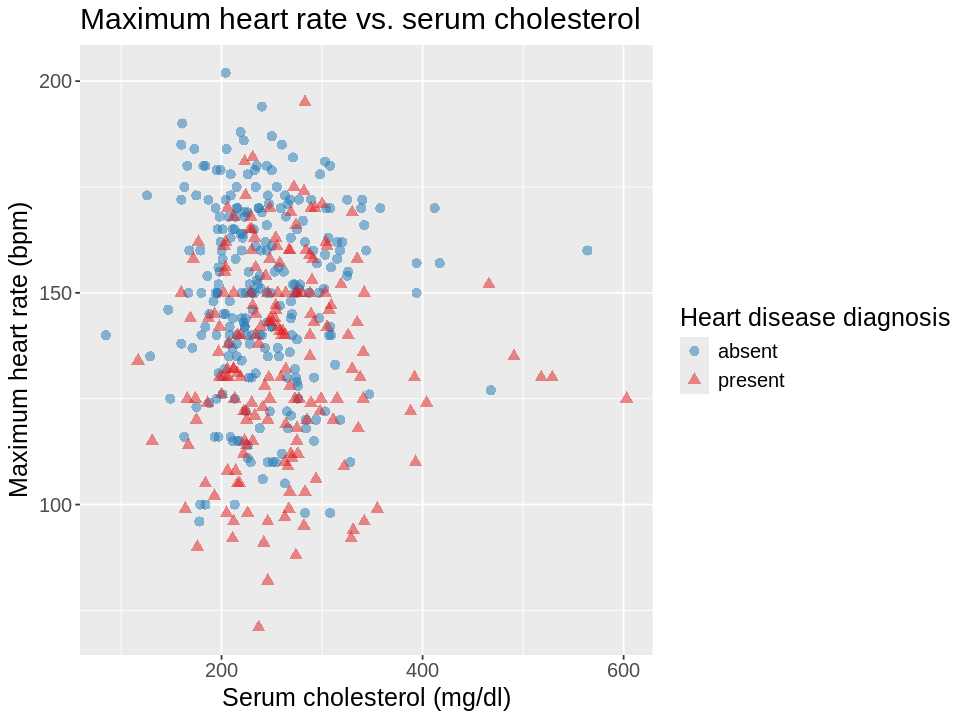

In [15]:
options(repr.plot.width = 8, repr.plot.height = 6)

thalach_vs_chol_plot <- heart_disease_training |>
    ggplot(aes(x = chol, y = thalach, colour = diagnosis, shape = diagnosis)) +
        geom_point(alpha = 0.5, size = 2.5) +
        labs(x = "Serum cholesterol (mg/dl)",
             y = "Maximum heart rate (bpm)",
             colour = "Heart disease diagnosis",
             shape = "Heart disease diagnosis",
             title = "Maximum heart rate vs. serum cholesterol") +
        # Use some color blind friendly colors
        scale_color_manual(values = c("#1F78B4", "#E31A1C")) +
        theme(text = element_text(size = 15))

thalach_vs_chol_plot

Warning message:
“Removed 17 rows containing missing values or values outside the scale range
(`geom_point()`).”


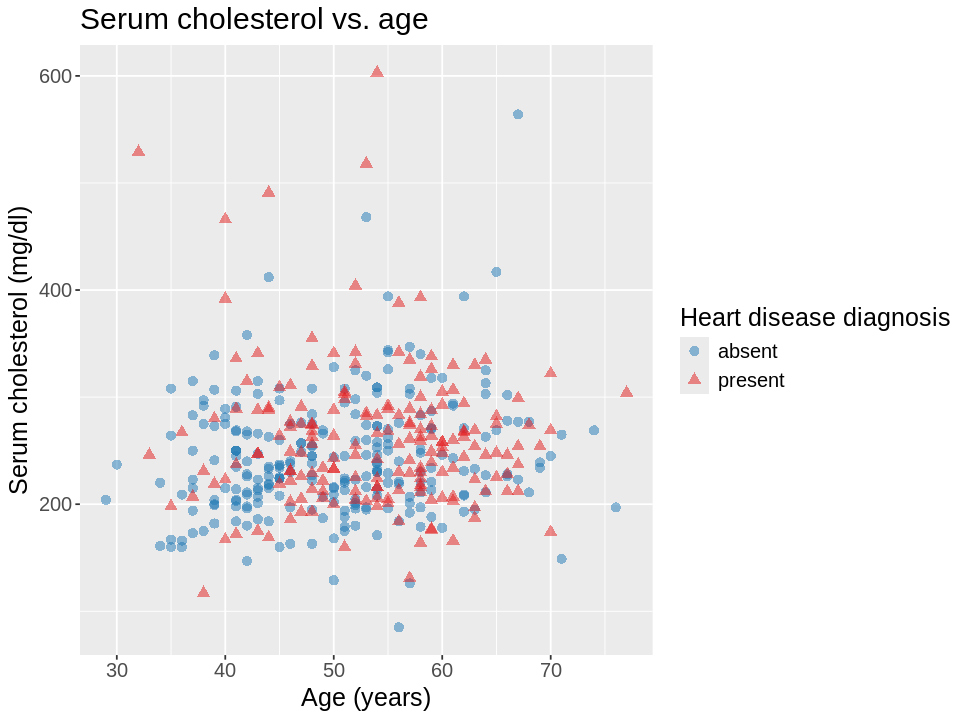

In [16]:
options(repr.plot.width = 8, repr.plot.height = 6)

chol_vs_age <- heart_disease_training |>
    ggplot(aes(x = age, y = chol, colour = diagnosis, shape = diagnosis)) +
        geom_point(alpha = 0.5, size = 2.5) +
        labs(x = "Age (years)",
             y = "Serum cholesterol (mg/dl)",
             colour = "Heart disease diagnosis",
             shape = "Heart disease diagnosis",
             title = "Serum cholesterol vs. age") +
        # Use some color blind friendly colors
        scale_color_manual(values = c("#1F78B4", "#E31A1C")) +
        theme(text = element_text(size = 15))

chol_vs_age

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


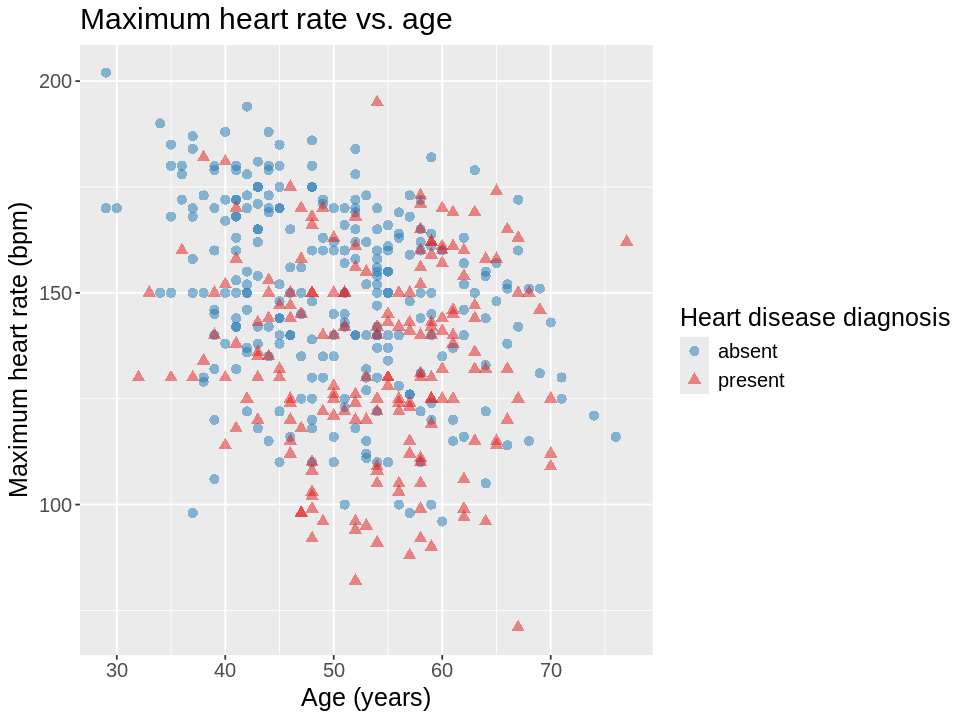

In [17]:
options(repr.plot.width = 8, repr.plot.height = 6)

thalach_vs_age <- heart_disease_training |>
    ggplot(aes(x = age, y = thalach, colour = diagnosis, shape = diagnosis)) +
        geom_point(alpha = 0.5, size = 2.5) +
        labs(x = "Age (years)",
             y = "Maximum heart rate (bpm)",
             colour = "Heart disease diagnosis",
             shape = "Heart disease diagnosis",
             title = "Maximum heart rate vs. age") +
        # Use some color blind friendly colors
        scale_color_manual(values = c("#1F78B4", "#E31A1C")) +
        theme(text = element_text(size = 15))

thalach_vs_age

## Model training and tuning

## Evaluating model performance

## Discussion

TODO

## References

TODO